# 下載套件(計算技術指標，抓Yahoo資料)

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install yfinance
!pip install mpl_finance

--2022-12-26 03:42:34--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-12-26 03:42:34--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://pilotfiber.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-12-26 03:42:34--  http://pilotfiber.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving pilotfibe

# 載入套件

In [ ]:
#基本套件
import numpy as np
import pandas as pd
#抓資料
import yfinance as yf
#計算技術指標
import talib
from talib import abstract
#畫圖
import matplotlib.pyplot as plt
import mpl_finance as mpf#畫K線
#正規化
from sklearn.preprocessing import MinMaxScaler
#資料分割
from sklearn.model_selection import train_test_split
#模型
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Dense, Activation, Conv1D, Flatten,LSTM,Dropout,MaxPooling1D

# 資料前處理

In [ ]:
def make_data(ticker, start_date, end_date):

  #從yahoo抓資料
  df=yf.download(ticker, start_date, end_date) 

  #刪除NAN值
  df = df.dropna()

  # 確認價量資料表 df 的值都是 float 格式
  df[['Open','High','Low','Close','Volume','Adj Close']] = df[['Open','High','Low','Close','Volume','Adj Close']].astype('float')

  #修改欄位標籤讓talib可以讀取#為了之後要計算技術指標
  df = df.rename(columns = {'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adj close', 'Volume': 'volume'})

  #計算調整過後的股價並覆寫到df
  df["adjfactor"] = df["adj close"]/df["close"]#計算調整因子
  df["open"] = df["adjfactor"]*df["open"]
  df["high"] = df["adjfactor"]*df["high"]
  df["low"] = df["adjfactor"]*df["low"]
  df["close"] = df["adjfactor"]*df["close"]

  #把沒用的欄位刪掉
  df = df.drop("adj close",axis=1)

  #手動計算位移(隔一天的價格)
  tmp=list()
  for i in range(1,len(df)):
    tmp.append(df["open"][i])
  tmp.append(np.nan)
  df["nextopen"] = tmp

  tmp=list()
  for i in range(1,len(df)):
    tmp.append(df["high"][i])
  tmp.append(np.nan)
  df["nexthigh"] = tmp

  tmp=list()
  for i in range(1,len(df)):
    tmp.append(df["low"][i])
  tmp.append(np.nan)
  df["nextlow"] = tmp

  tmp=list()
  for i in range(1,len(df)):
    tmp.append(df["close"][i])
  tmp.append(np.nan)
  df["nextclose"] = tmp 

  #計算隔一天漲幅(%四捨五入2位)
  df["nextopenUpDown"] = round((df.nextopen/df.open-1)*100,2)
  df["nexthighUpDown"] = round((df.nexthigh/df.high-1)*100,2)
  df["nextlowUpDown"] = round((df.nextlow/df.low-1)*100,2)
  df["nextcloseUpDown"] = round((df.nextclose/df.close-1)*100,2)

  #計算K線型態(除以當日收盤價%四捨五入2位)
  tmp=list()
  for i in range(0,len(df)):
    tmp.append(df["high"][i]-max(df["open"][i],df["close"][i]))
  df["上影線"] = tmp
  df["上影線"] = round(100*df["上影線"]/df["close"],2)

  tmp=list()
  for i in range(0,len(df)):
    tmp.append(min(df["close"][i],df["open"][i])-df["low"][i])
  df["下影線"] = tmp
  df["下影線"] = round(100*df["下影線"]/df["close"],2)

  tmp=list()
  for i in range(0,len(df)):
    tmp.append(max(df["close"][i],df["open"][i])-min(df["close"][i],df["open"][i]))
  df["實體線"] = tmp
  df["實體線"] = round(100*df["實體線"]/df["close"],2)

  tmp=list()
  tmp.append(np.nan)
  for i in range(0,len(df)-1):
    tmp.append(df["上影線"][i])
  df["前一日上影線"] = tmp

  tmp=list()
  tmp.append(np.nan)
  for i in range(0,len(df)-1):
    tmp.append(df["下影線"][i])
  df["前一日下影線"] = tmp

  tmp=list()
  tmp.append(np.nan)
  for i in range(0,len(df)-1):
    tmp.append(df["實體線"][i])
  df["前一日實體線"] = tmp

  tmp=list()
  tmp.append(np.nan)
  for i in range(1,len(df)):
    tmp.append(df["open"][i]-df["close"][i-1])
  df["開盤型態"] = tmp
  df["開盤型態"] = round(100*df["開盤型態"]/df["close"],2)

  tmp=list()
  tmp.append(np.nan)
  for i in range(1,len(df)):
    tmp.append(df["close"][i]-df["close"][i-1])
  df["收盤型態"] = tmp
  df["收盤型態"] = round(100*df["收盤型態"]/df["close"],2)

  tmp=list()
  tmp.append(np.nan)
  tmp.append(np.nan)
  tmp.append(np.nan)
  tmp.append(np.nan)
  tmp.append(np.nan)
  tmp.append(np.nan)
  for i in range(6,len(df)):
    tmp.append(df["close"][i-1]-df["close"][i-6])
  df["前5日價格趨勢"] = tmp#前一天收盤價 - 6日前收盤價
  df["前5日價格趨勢"] = round(100*df["前5日價格趨勢"]/df["close"],2)

  tmp = talib.SMA(df.volume, timeperiod=10)
  tmp = (df.volume-tmp)/tmp
  df["前10日均量差比率"] = tmp#當日量與10日均量的差/10日均量
  df["前10日均量差比率"] = round(100*df["前10日均量差比率"],2)

  #計算100多種技術指標
  # 這裡示範全部 158 種技術指標
  ta_list = talib.get_functions()
  # 迴圈執行，看看結果吧！
  for x in ta_list:
    try:
      # x 為技術指標的代碼，透過迴圈填入，再透過 eval 計算出 output
      output = eval('abstract.'+x+'(df)')
      # 如果輸出是一維資料，幫這個指標取名為 x 本身；多維資料則不需命名
      output.name = x.lower() if type(output) == pd.core.series.Series else None
      # 透過 merge 把輸出結果併入 df DataFrame
      df = pd.merge(df, pd.DataFrame(output), left_on = df.index, right_on = output.index)
      df = df.set_index('key_0')
    except:
      print(x)
  #刪除沒用的技術指標
  df=df.drop(['acos','asin','cdl2crows', 'cdl3blackcrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside', 'cdl3starsinsouth', 'cdl3whitesoldiers', 
            'cdlabandonedbaby', 'cdladvanceblock', 'cdlbelthold', 'cdlbreakaway', 'cdlclosingmarubozu', 'cdlconcealbabyswall', 'cdlcounterattack', 
            'cdldarkcloudcover', 'cdldoji', 'cdldojistar', 'cdldragonflydoji', 'cdlengulfing', 'cdleveningdojistar', 'cdleveningstar', 
            'cdlgapsidesidewhite', 'cdlgravestonedoji', 'cdlhammer', 'cdlhangingman', 'cdlharami', 'cdlharamicross', 'cdlhighwave', 'cdlhikkake', 
            'cdlhikkakemod', 'cdlhomingpigeon', 'cdlidentical3crows', 'cdlinneck', 'cdlinvertedhammer', 'cdlkicking', 'cdlkickingbylength', 
            'cdlladderbottom', 'cdllongleggeddoji', 'cdllongline', 'cdlmarubozu', 'cdlmatchinglow', 'cdlmathold', 'cdlmorningdojistar', 
            'cdlmorningstar', 'cdlonneck', 'cdlpiercing', 'cdlrickshawman', 'cdlrisefall3methods', 'cdlseparatinglines', 'cdlshootingstar', 
            'cdlshortline', 'cdlspinningtop', 'cdlstalledpattern', 'cdlsticksandwich', 'cdltakuri', 'cdltasukigap', 'cdlthrusting', 'cdltristar', 
            'cdlunique3river', 'cdlupsidegap2crows', 'cdlxsidegap3methods'], axis=1)

  #顯示所有columns
  #pd.set_option("display.max_columns", None)  

  #刪除NAN值
  df = df.dropna()

  #將資料欄位拆成五大欄位分別是1.調整後該收高低2.K線型態3.技術指標4.隔一天的開收高低
  df_adj = df[['open','high','low','close','volume']]
  df_y = df[['nextopen','nexthigh','nextlow','nextclose']]
  df_yUpDown = df[['nextopenUpDown','nexthighUpDown','nextlowUpDown','nextcloseUpDown']]
  df_K = df[['前5日價格趨勢','前10日均量差比率','開盤型態','收盤型態','上影線','下影線','實體線','前一日上影線','前一日下影線','前一日實體線']]
  df_T = df.drop(['open','high','low','close','volume','nextopen','nexthigh','nextlow','nextclose',
                '前5日價格趨勢','前10日均量差比率','開盤型態','收盤型態','上影線','下影線','實體線','前一日上影線','前一日下影線','前一日實體線',
                'nextopenUpDown','nexthighUpDown','nextlowUpDown','nextcloseUpDown'],axis=1)
  
  return df_adj, df_T,  df_K,  df_y, df_yUpDown

# 訓練資料

In [ ]:
df_adj, df_T,  df_K,  df_y, df_yUpDown= make_data("2303.TW", "2015-01-01", "2022-08-31")

[*********************100%***********************]  1 of 1 completed
MAVP


In [ ]:
Backdata = list()

for k in range(0,41):
  #分割訓練資料
  train_adj = df_adj[:-42+k]
  train_y = df_y[:-42+k]

  #正規化
  sc_adj = MinMaxScaler(feature_range=(0,1))
  train_adj = sc_adj.fit_transform(train_adj)
  sc_y = MinMaxScaler(feature_range=(0,1))
  train_y = sc_y.fit_transform(train_y)

  X_train = []
  y_train = []

  for i in range (10,train_y.shape[0]): #60 : timestep // 1149 : length of the data
      X_train.append(train_adj[i-10:i]) 
      y_train.append(train_y[i])
  X_train,y_train = np.array(X_train),np.array(y_train)
  X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2])) #adding the batch_size axis

  #模型訓練
  flag = 2
  if(flag==1):#CNN1D
    model = Sequential()
    # inputs = Input(shape=(window_size,))
    model.add(Conv1D(input_shape=(X_train.shape[1], X_train.shape[2]), filters = 32, kernel_size=3, strides=1, \
                 activation='relu'))
    model.add(Conv1D(filters = 32, kernel_size=3, strides=1, \
                 activation='relu'))
    model.add(Flatten()) #由於前面兩個conv1D的Kerner size都是3，所以原本長度是7的資料會變成3，而channels為16，所以一起攤平變成48
    model.add(Dense(4)) #輸出4個值
    print(model.input_shape) #可以把輸入的型態秀出來
    model.summary()
    opt = keras.optimizers.Adam(lr=0.001, decay=1e-6, clipvalue=5)

    model.compile( loss='mse', optimizer=opt, metrics=['mse'] )
    hist=model.fit(X_train, y_train, epochs=100) 

  elif(flag==2):#LSTM
    model = Sequential()

    model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units=100, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=100, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units =4))
    model.compile(optimizer='adam',loss="mean_squared_error")
    hist=model.fit(X_train, y_train, epochs=20) 
  
  elif(flag==3):#CNN1D-LSTM
    model = Sequential()

    model.add(Conv1D(input_shape=(X_train.shape[1], X_train.shape[2]), filters = 16, kernel_size=2, strides=1, activation='relu'))
    #model.add(Conv1D(filters = 16, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))

    #model.add(Flatten())

    model.add(LSTM(units=64, return_sequences = False,input_shape =(X_train.shape[1],5)))
    #model.add(Dropout(0.2))

    #model.add(LSTM(units=10, return_sequences = False))
    #model.add(Dropout(0.2))

    model.add(Dense(units=4, activation='linear'))
    model.compile(optimizer='adam',loss="mean_squared_error")

    print(model.summary()) 
    hist=model.fit(X_train, y_train, epochs=50)#


  #損失函數
  #plt.plot(hist.history['loss'])
  #plt.title('model loss')
  #plt.ylabel('loss')
  #plt.xlabel('epoch')
  #plt.legend(['train'], loc='upper left')
  #plt.show()


  #預測資料
  test_adj = df_adj[-52+k:-41+k]
  test_y = df_y[-52+k:-41+k]
  input = sc_adj.transform(test_adj)
  X_test = []
  for i in range(10,input.shape[0]): #doing the same preivous preprocessing 
      X_test.append(input[i-10:i])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))
  y_pred = model.predict(X_test) #predicting the new values
  predicted_price = sc_y.inverse_transform(y_pred) #inversing the scaling transformation for ploting
  
  #把每次訓練的資料存起來
  Backdata.append(predicted_price)

Epoch 1/20
54/54 [==============================] - 21s 71ms/step - loss: 0.0129
Epoch 2/20
54/54 [==============================] - 2s 39ms/step - loss: 0.0026
Epoch 3/20
54/54 [==============================] - 2s 32ms/step - loss: 0.0024
Epoch 4/20
54/54 [==============================] - 2s 33ms/step - loss: 0.0022
Epoch 5/20
54/54 [==============================] - 2s 32ms/step - loss: 0.0022
Epoch 6/20
54/54 [==============================] - 2s 32ms/step - loss: 0.0019
Epoch 7/20
54/54 [==============================] - 2s 32ms/step - loss: 0.0019
Epoch 8/20
54/54 [==============================] - 3s 53ms/step - loss: 0.0021
Epoch 9/20
54/54 [==============================] - 2s 32ms/step - loss: 0.0019
Epoch 10/20
54/54 [==============================] - 2s 32ms/step - loss: 0.0019
Epoch 11/20
54/54 [==============================] - 2s 32ms/step - loss: 0.0019
Epoch 12/20
54/54 [==============================] - 2s 32ms/step - loss: 0.0019
Epoch 13/20
54/54 [=================

# 調整資料結構

In [ ]:
#將[open,high,low,close]轉換成open=list(),high=list()...
open1=list()
open2=list()
high1=list()
high2=list()
low1=list()
low2=list()
close1=list()
close2=list()

for i in range(0,len(df_y[-42:-1])):
  open1.append(Backdata[i][0][0])
  open2.append(df_y[-42:-1]["nextopen"][i])
  high1.append(Backdata[i][0][1])
  high2.append(df_y[-42:-1]["nexthigh"][i])
  low1.append(Backdata[i][0][2])
  low2.append(df_y[-42:-1]["nextlow"][i])
  close1.append(Backdata[i][0][3])
  close2.append(df_y[-42:-1]["nextclose"][i])

# 畫出K線

(<matplotlib.collections.LineCollection at 0x7fcad473d5b0>,
 <matplotlib.collections.PolyCollection at 0x7fcad473d130>)

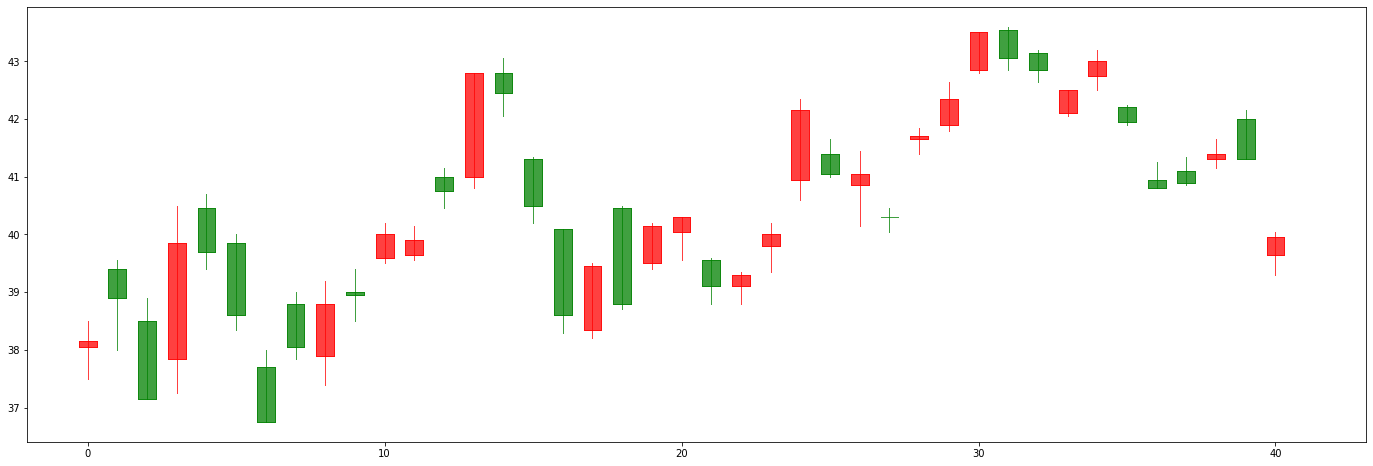

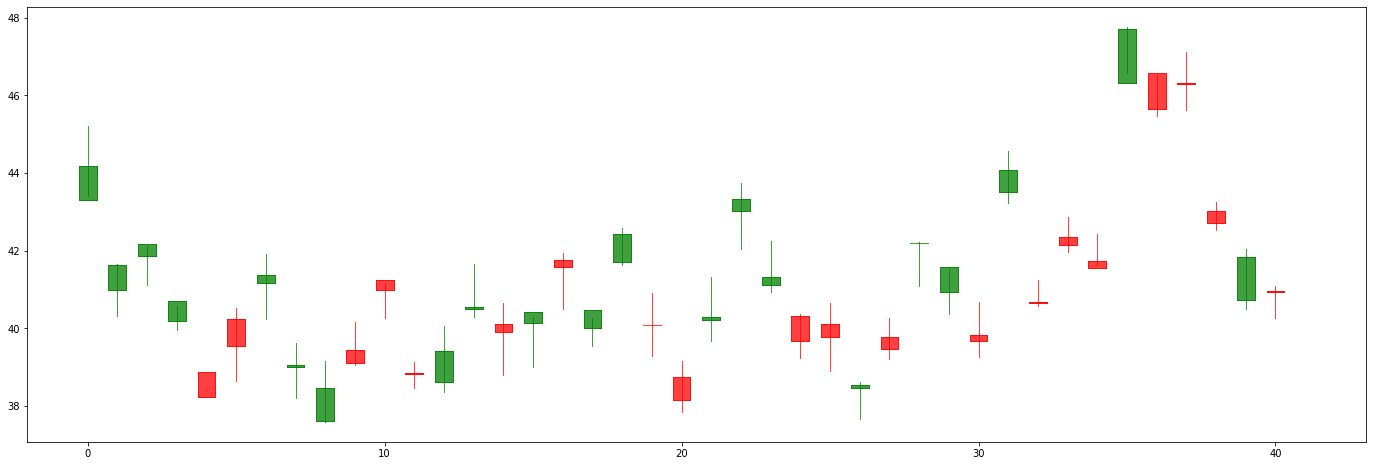

In [ ]:
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
mpf.candlestick2_ochl(ax, open2, close2, high2, low2, width=0.6, colorup='r', colordown='g', alpha=0.75)
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
mpf.candlestick2_ochl(ax, open1, close1, high1, low1, width=0.6, colorup='r', colordown='g', alpha=0.75)

# Residual分析

In [ ]:
#計算residual
residual = [[],[],[],[]]#第一個list放開盤價，第二個放最高價以此類推

for i in range(0,len(open1)):
    residual[0].append(abs(open1[i]-open2[i]))
    residual[1].append(abs(high1[i]-high2[i]))
    residual[2].append(abs(low1[i]-low2[i]))
    residual[3].append(abs(close1[i]-close2[i]))

#找最大最小residual index
Maxindex=[0,0,0,0]
Minindex=[0,0,0,0]
for i in range(0,4):
  for j in range(0,len(residual[i])):
    if residual[i][j] == max(residual[i]):
      Maxindex[i] = j
    if residual[i][j] == min(residual[i]):
      Minindex[i] = j

Text(0, 0.5, 'Stock Price')

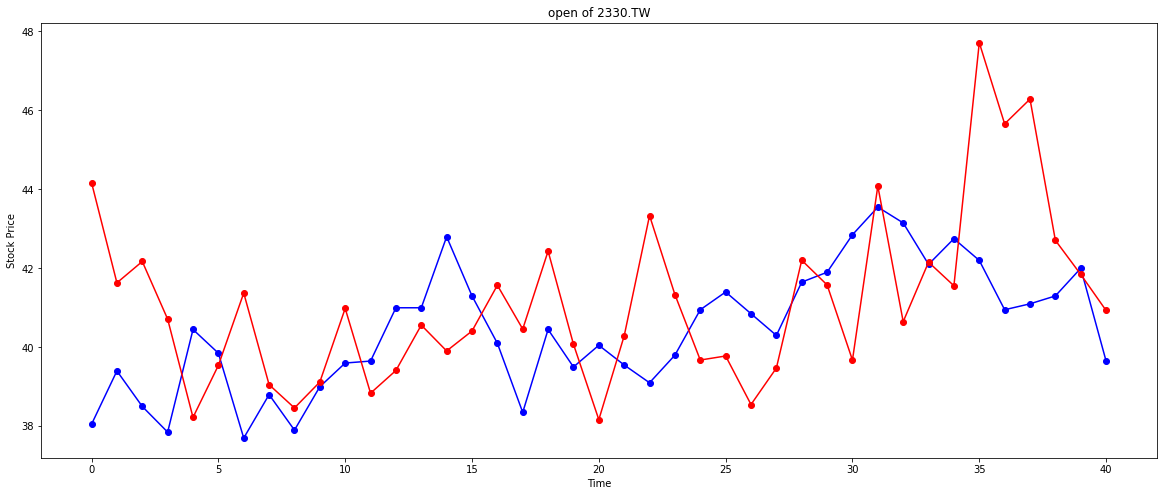

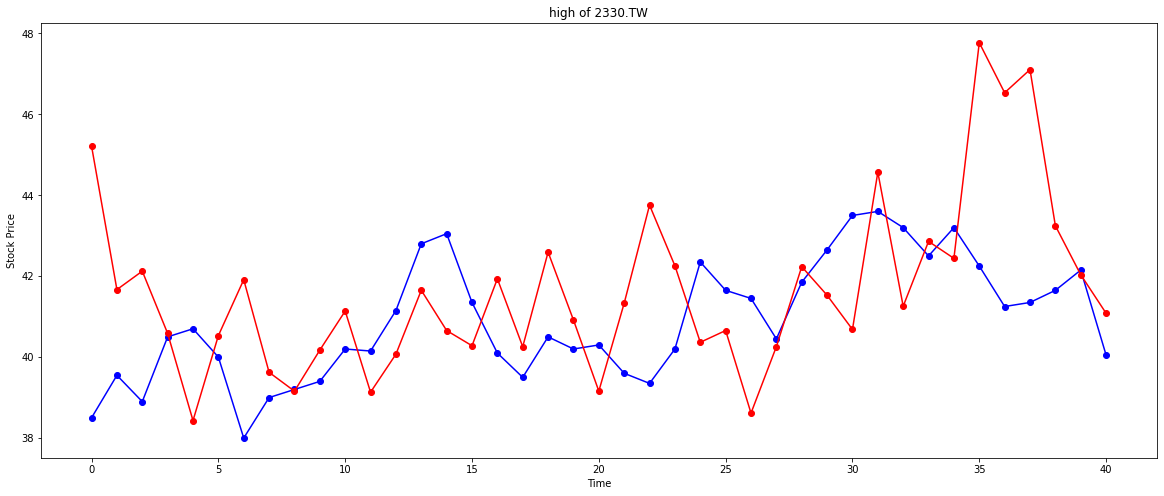

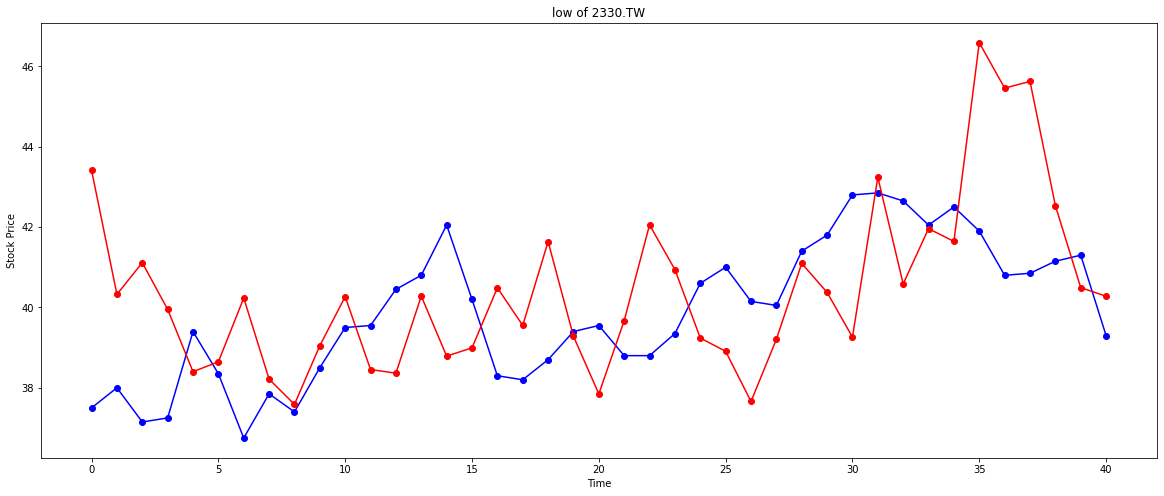

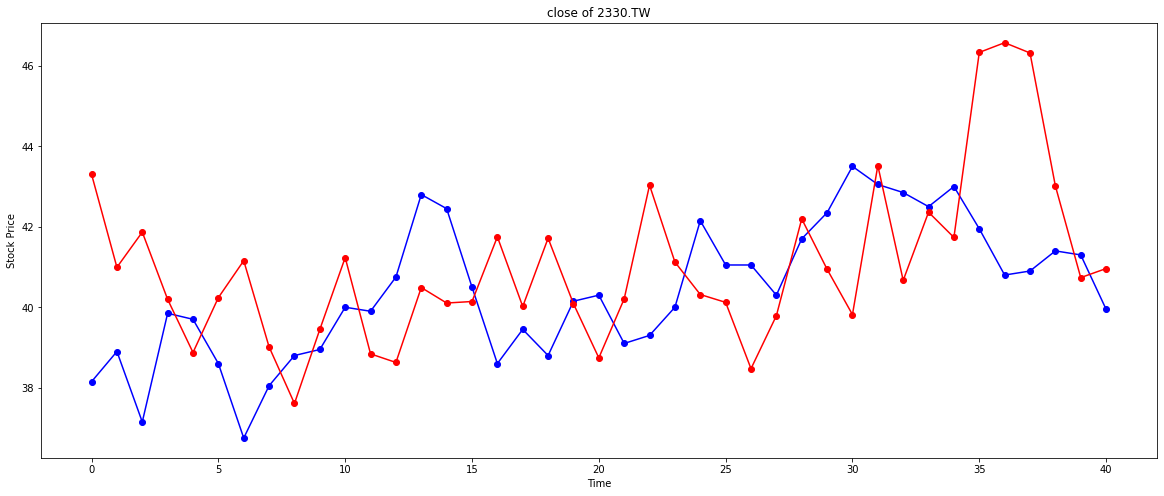

In [ ]:
#畫圖
plt.figure(figsize=(20,8))
plt.plot(open2,'-o', color = 'blue', label = 'Actual Stock Price')
plt.plot(open1,'-o', color = 'red', label = 'Predicted Stock Price')
plt.title("open of 2330.TW")
plt.xlabel('Time')
plt.ylabel('Stock Price')

plt.figure(figsize=(20,8))
plt.plot(high2,'-o', color = 'blue', label = 'Actual Stock Price')
plt.plot(high1,'-o', color = 'red', label = 'Predicted Stock Price')
plt.title("high of 2330.TW")
plt.xlabel('Time')
plt.ylabel('Stock Price')

plt.figure(figsize=(20,8))
plt.plot(low2,'-o', color = 'blue', label = 'Actual Stock Price')
plt.plot(low1,'-o', color = 'red', label = 'Predicted Stock Price')
plt.title("low of 2330.TW")
plt.xlabel('Time')
plt.ylabel('Stock Price')

plt.figure(figsize=(20,8))
plt.plot(close2,'-o', color = 'blue', label = 'Actual Stock Price')
plt.plot(close1,'-o', color = 'red', label = 'Predicted Stock Price')
plt.title("close of 2330.TW")
plt.xlabel('Time')
plt.ylabel('Stock Price')

# 投資策略

In [ ]:
#預測明天漲就在明天開盤價進場
#漲超過2%就出場
#如果今天沒有2%就在收盤價出場
cash = 1000000
flag_2 = 0  #0->沒進場；1->進場了
for i in range(1,len(open1)):
  if(flag_2==0 and close2[i-1]>close1[i]):#預測明天漲就在明天開盤價進場
    cash /= open2[i]
    flag_2=1
  if(flag_2==1 and high2[i]/open2[i]>=1.02):#漲超過2%就出場
    cash = cash * open2[i] * 1.02
    flag_2=0
  elif(flag_2==1 and high2[i]/open2[i]<1.02):#如果今天沒有2%就在收盤價出場
    cash *= close2[i]
    flag_2=0
  
print("cash = ", cash)

cash =  1009282.4517360396
